# LFA for the Laplacian on a hexagonal grid

We reproduce results from https://epubs.siam.org/doi/10.1137/070709566, i.e., the numbers given in Table 6.2,
Rows corresponding to ``V(1,1)`` Cycles,
Columns Analytical,  ``One-Grid`` (=smoothing analysis) and ``Two-grid``.

The results from the smoothing analysis in this notebook does not match the numbers of the smoothing analysis of this paper. This is due to the fact, that in this paper they filtered out the wavefunctions $e^{2\pi i \langle k, x \rangle}$ with frequencies $k=k_1 b_1 + k_2 b_2$, $(k_1,k_2) \in [-\frac{1}{4}, \frac{1}{4}]$, where $B=(b_1 \ b_2)$ is the dual lattice basis. This set $\{k=k_1 b_1 + k_2 b_2 : (k_1,k_2) \in [-\frac{1}{4}, \frac{1}{4}] \}$ is a paralellotope.  In contrast, we filter out the actual lowest frequencies, that is, the center quarter of the First Brioullin zone of the hexagonal grid, which has again a hexagonal shape (cf. https://en.wikipedia.org/wiki/Brillouin_zone and https://en.wikipedia.org/wiki/Voronoi_diagram). 

The numbers in the table correspond to the square root of the spectral radius, cf. equation (4.14). 


In [1]:
import alfa
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def laplace2D_hex():
    A = np.asarray([[1,1/2],[0,np.sqrt(3)/2.0]]) #lattice basis
    sd = np.asarray([[0, 0]]) # structure element of domain
    sc = np.asarray([[0, 0]]) # structure element of codomain 
    C = alfa.Crystal(A, [sd,sc])
    L = alfa.Operator(C)

    L.add_multiplier(np.eye(1) * -6, np.array([0, 0]))
    L.add_multiplier(np.eye(1), np.array([1, 0]))
    L.add_multiplier(np.eye(1), np.array([-1, 0]))
    L.add_multiplier(np.eye(1), np.array([0, 1]))
    L.add_multiplier(np.eye(1), np.array([0, -1]))
    L.add_multiplier(np.eye(1), np.array([-1, 1]))
    L.add_multiplier(np.eye(1), np.array([1, -1]))
    return L

L = laplace2D_hex()


# definition of fw_restriction:
def fw_restriction_hex():
    A = 2*np.asarray([[1,1/2],[0,np.sqrt(3)/2.0]]) #lattice basis
    sd = np.asarray([[0, 0], .5*A@[1, 0], .5*A@[0, 1], .5*A@[1, 1]])  # domain
    sc = np.asarray([[0, 0]])  # codomain
    C = alfa.Crystal(A, [sd,sc])
    L = alfa.Operator(C)

    L.add_multiplier(np.asarray([[1, 1 / 2, 1 / 2, 0]]), np.asarray([0, 0]))
    L.add_multiplier(np.asarray([[0, 0, 1 / 2, 1 / 2]]), np.asarray([0, -1]))
    L.add_multiplier(np.asarray([[0, 1 / 2, 0, 1 / 2]]), np.asarray([-1, 0]))

    return L

R = fw_restriction_hex()


I = alfa.tools.identity(L.C)
P = R.transpose()
Lc = R@L@P

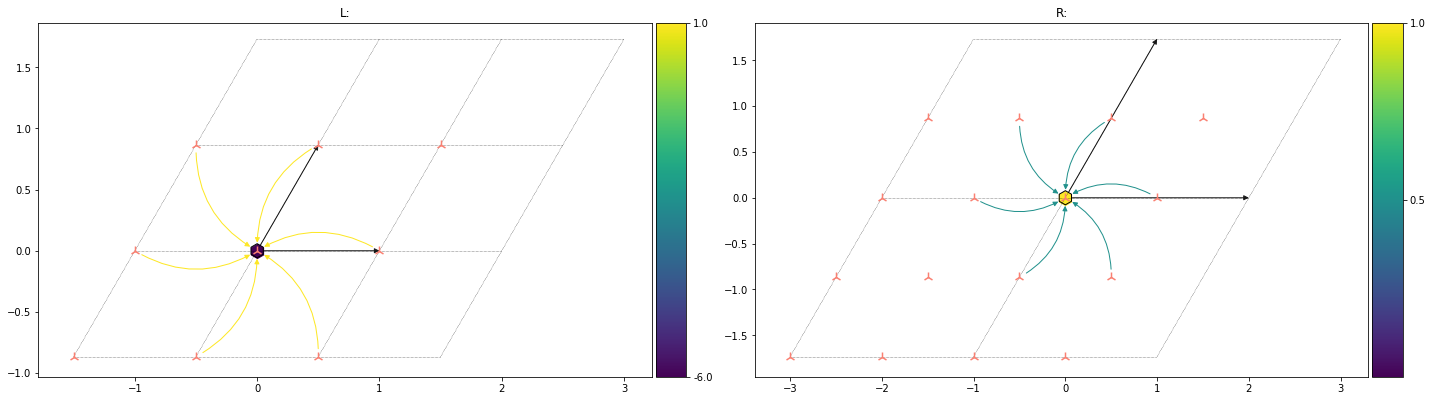

In [3]:
plt.gcf().set_figwidth(13)
plt.subplot(121)
L.plot()
plt.title('L:')
plt.subplot(122)
R.plot()
plt.title('R:');
plt.gcf().set_figwidth(20)
plt.gcf().set_figheight(10)
plt.tight_layout()

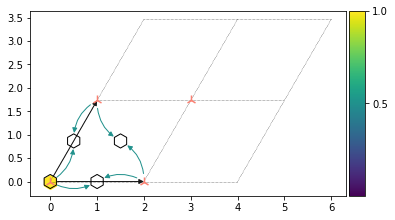

In [4]:
P.plot()

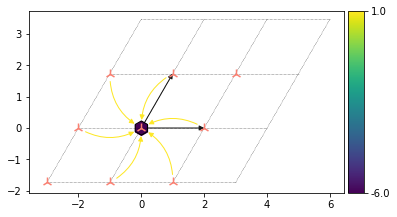

In [5]:
Lc.plot()

### Scalar Jacobi Smoothing (without relaxation)

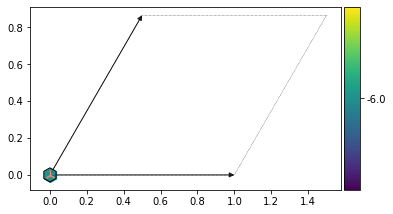

In [6]:
# Scalar Jacobi
Sjac = alfa.tools.central_multiplier_of(L, [0])
#plot:
plt.figure()
plt.gcf().set_figwidth(13)
plt.subplot(121)
Sjac.plot()  


In [7]:

X = {x:eval(x) for x in ['I','L','Sjac','P','Lc','R']}

Gjac_str = "('I' - pinv('Sjac')@'L')"
CGC_str = "('I'-'P'@pinv('Lc')@'R'@'L')"

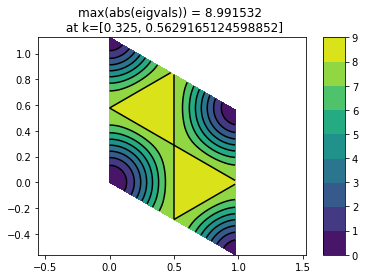

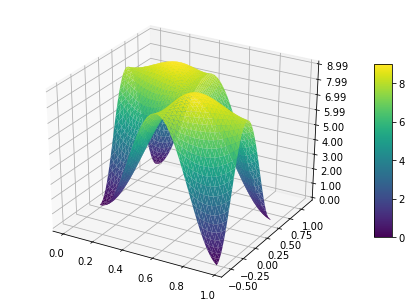

In [8]:
# Plot of the spectrum of the underlying Laplacian

Laplacian = alfa.Operator_Composition(X,"'L'")
Laplacian.discretize_frequency_space(40)
Laplacian.compute_spectrum()
Laplacian.plot_spectrum()
plt.figure()
Laplacian.plot_spectrum_3d()

Square root of the spectral radius: 0.5


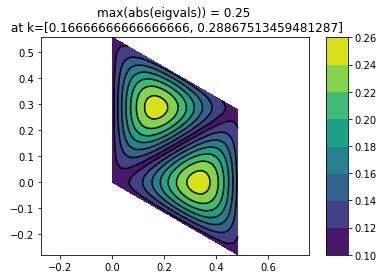

In [9]:
# Smoothing analysis

smoother = alfa.Operator_Composition(X ,  Gjac_str+"@"+Gjac_str, alfa.Lattice(I.C.A*2))
smoother.discretize_frequency_space(30)
smoother.compute_spectrum(None, L.C, 1)


plt.figure()
smoother.plot_spectrum()



print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(smoother._df['eig_0'].values))))

Square root of the spectral radius: 0.48591265


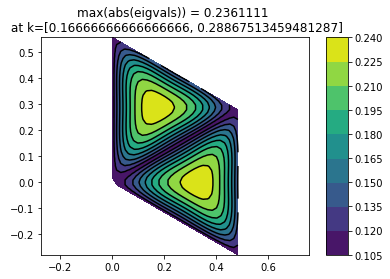

In [10]:
twogrid = alfa.Operator_Composition(X ,   Gjac_str + "@"+ CGC_str +"@"+ Gjac_str)

twogrid.compute_spectrum(30)
# The constant function corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid._df.at[0, 'eig_0'] = np.nan

plt.figure()

twogrid.plot_spectrum(.5)



print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(twogrid._df['eig_0'].values))))

# lex. Gauss-Seidel

In [11]:
Sgs = alfa.tools.lower_triangle_of(L)
X = {**X, **{'Sgs':Sgs}}
Ggs_str = "('I' - pinv('Sgs')@'L')"

Square root of the spectral radius: 0.45332092


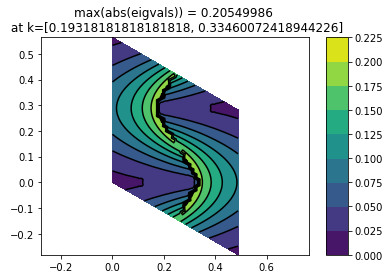

In [12]:
# Smoothing analysis

smoother = alfa.Operator_Composition(X ,  Ggs_str+"@"+Ggs_str, alfa.Lattice(I.C.A*2))
smoother.discretize_frequency_space(44)
smoother.compute_spectrum(None, L.C, 1)

plt.figure()
smoother.plot_spectrum()



print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(smoother._df['eig_0'].values))))

Square root of the spectral radius: 0.3515824


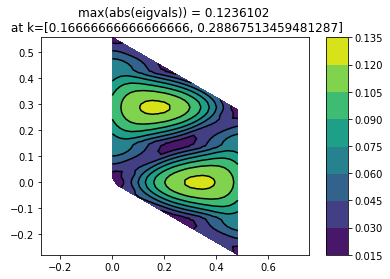

In [13]:
twogrid_gs = alfa.Operator_Composition(X ,   Ggs_str + "@"+ CGC_str +"@"+ Ggs_str)

twogrid_gs.compute_spectrum(30)
# The constant function corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid_gs._df.at[0, 'eig_0'] = np.nan

plt.figure()
twogrid_gs.plot_spectrum(.5)



print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(twogrid_gs._df['eig_0'].values))))

# Coarse-Fine smoothing

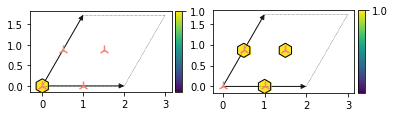

In [14]:
A = 2*np.asarray([[1,1/2],[0,np.sqrt(3)/2.0]]) #lattice basis
sd = np.asarray([[0, 0], .5*A@[1, 0], .5*A@[0, 1], .5*A@[1, 1]])  # domai

sc_f = np.asarray([ .5*A@[1, 0], .5*A@[0, 1], .5*A@[1, 1]])  # domai

sc_c = np.asarray([[0, 0]])  # domai

C_c = alfa.Crystal(A, [sd,sc_c])
C_f = alfa.Crystal(A, [sd,sc_f])

R_c= alfa.Operator(C_c)
R_f = alfa.Operator(C_f)


R_c = alfa.Operator(C_c)
R_c.add_multiplier(np.asarray([[1, 0,0,0 ]]), np.asarray([0, 0]))

R_f = alfa.Operator(C_f)
R_f.add_multiplier(np.asarray([[0, 1,0,0 ],[0, 0,1,0 ],[0, 0,0,1 ]]), np.asarray([0, 0]))


plt.figure()
plt.subplot(121)
R_c.plot()

plt.subplot(122)
R_f.plot()

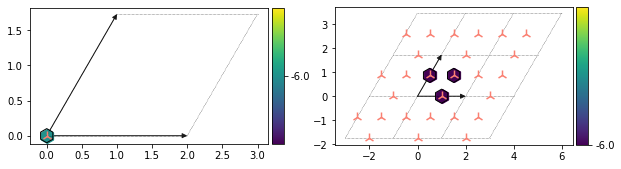

In [15]:
S_c = R_c@L@R_c.transpose()
S_f = R_f@L@R_f.transpose()
for i in range(len(S_f.m)):
    S_f.m[i].matrix = np.diag(np.diag(S_f.m[i].matrix))

plt.figure(figsize=(10,10))
plt.subplot(121)
S_c.plot()

plt.subplot(122)
S_f.plot()


Square root of the spectral radius: 0.33333334


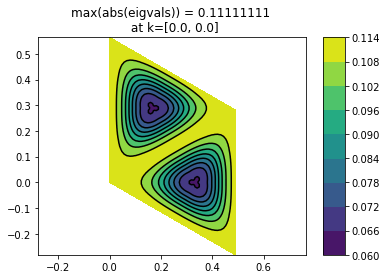

In [16]:
Gc_str = "('I'-'R_c'.transpose()@pinv('S_c')@'R_c'@'L')"
Gf_str = "('I'-'R_f'.transpose()@pinv('S_f')@'R_f'@'L')"

X = {**X, **{x:eval(x) for x in ['R_c','S_c','R_f','S_f']} }
smoother_cf = alfa.Operator_Composition(X, Gf_str +"@"+ Gc_str +"@" + Gf_str +"@"+ Gc_str, alfa.Lattice(I.C.A*2) )

#smoother_rb.discretize_frequency_space(22)
smoother_cf.compute_spectrum(44, L.C, 1)

plt.figure()
smoother_cf.plot_spectrum()

print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(smoother_cf._df['eig_0'].values))))

Square root of the spectral radius: 0.4006976


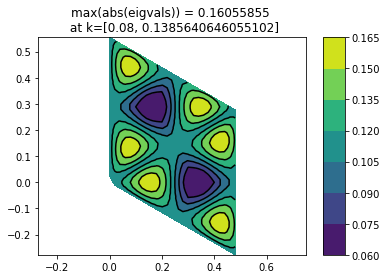

In [17]:


twogrid_cf = alfa.Operator_Composition(X, Gf_str+"@"+ Gc_str + "@" + CGC_str +"@"+ Gf_str+"@"+ Gc_str)

twogrid_cf.compute_spectrum(25)


# The constant function corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid_cf._df.at[0, 'eig_0'] = np.nan

plt.figure()
twogrid_cf.plot_spectrum()


print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(twogrid_cf._df['eig_0'].values))))

# Four Color scheme


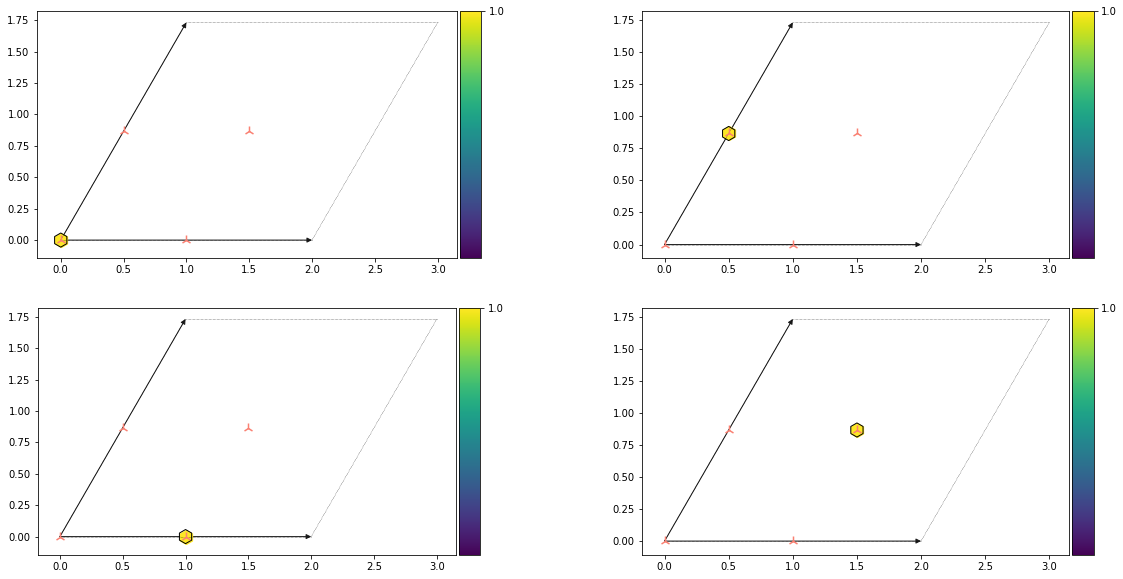

In [18]:
A = 2*np.asarray([[1,1/2],[0,np.sqrt(3)/2.0]]) #lattice basis

sd_4c = np.asarray([[0, 0], .5*A@[1, 0], .5*A@[0, 1], .5*A@[1, 1]])  # domai

sc_4c = [np.asarray([.5*A@[x,y]]) for x in [0,1] for y in [0,1]]


Y = {}
for i,x in enumerate(sc_4c):
    Y = {**Y, **{'R_4c_' + str(i): alfa.Operator(alfa.Crystal(A, [sd_4c, x]))}}
    

Y['R_4c_0'].add_multiplier(np.asarray([[1, 0,0,0 ]]), np.asarray([0, 0]))
Y['R_4c_1'].add_multiplier(np.asarray([[0, 0,1,0 ]]), np.asarray([0, 0]))
Y['R_4c_2'].add_multiplier(np.asarray([[0, 1,0,0 ]]), np.asarray([0, 0]))
Y['R_4c_3'].add_multiplier(np.asarray([[0, 0,0,1 ]]), np.asarray([0, 0]))

Z = {}
plt.figure(figsize=(20,10))
for i,key in enumerate(Y):
    plt.subplot(221 + i)
    Y[key].plot()
    Z = {**Z, **{'S_4c_' + str(i): Y[key]@L@Y[key].transpose() }}

In [19]:
X = {**X, **Y, **Z} 

G4c_str = ""
for j in [0,1,2,3]:
    if j>0:
        G4c_str = G4c_str + "@"
    G4c_str = G4c_str + "('I'- 'R_4c_" + str(j) + "'.transpose()@pinv('S_4c_"+ str(j) + "')@'R_4c_" + str(j) + "'@'L')"


Square root of the spectral radius: 0.22816318


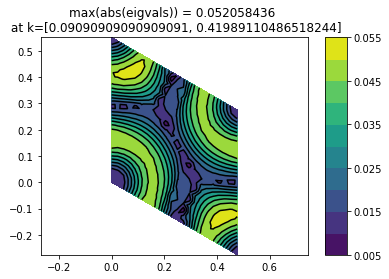

In [20]:

smoother_4c = alfa.Operator_Composition(X, G4c_str+ "@"+G4c_str, alfa.Lattice(I.C.A*2))
smoother_4c.discretize_frequency_space(22)
smoother_4c.compute_spectrum(None, L.C, 1)

smoother_4c.plot_spectrum()

print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(smoother_4c._df['eig_0'].values))))

Square root of the spectral radius: 0.20561932


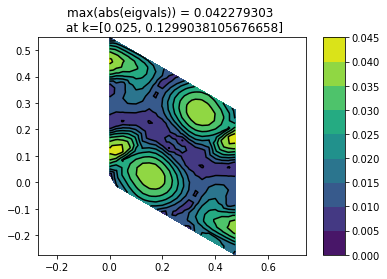

In [21]:



twogrid_4c = alfa.Operator_Composition(X,   G4c_str + "@" +CGC_str + "@" + G4c_str) # Gstr + "@" +

twogrid_4c.compute_spectrum(20)


# The constant function corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid_4c._df.at[0, 'eig_0'] = np.nan

plt.figure()
twogrid_4c.plot_spectrum()


print("Square root of the spectral radius:", np.sqrt(np.nanmax(np.abs(twogrid_4c._df['eig_0'].values))))
